In [1]:
import torch
import numpy as np
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
%matplotlib inline

from main import train_and_eval, train_loader, test_loader

### Visualize training and testing data

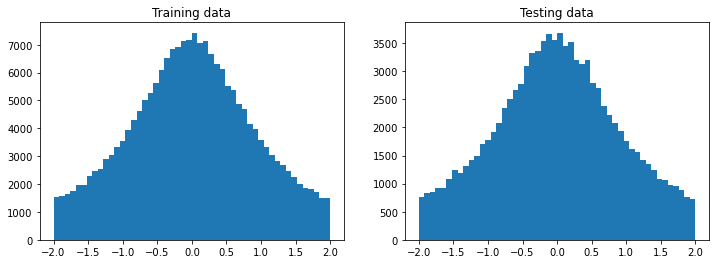

In [2]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Testing data')

### Train the composable flow model

In [ ]:
target_distribution = Uniform(0.0, 1.0)
flow, train_losses, test_losses = train_and_eval(150, 1e-2, train_loader, test_loader, target_distribution)

### View the losses

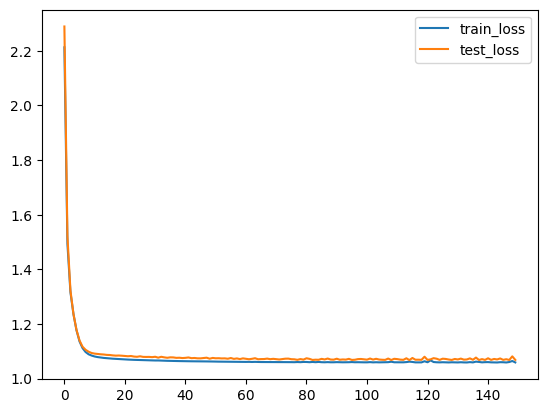

In [ ]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
plt.legend()

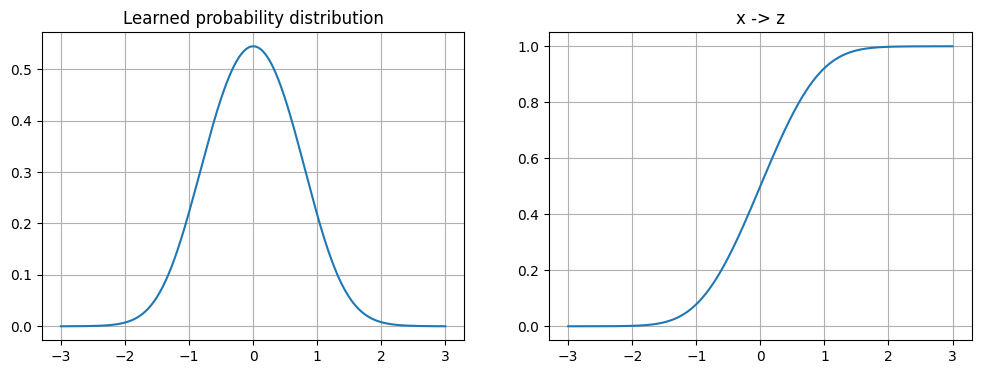

In [ ]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

### Empirical distribution of z

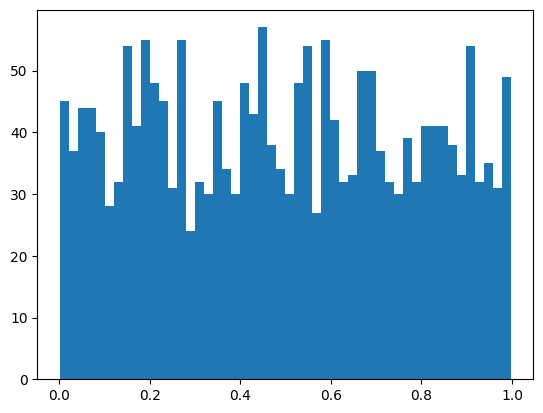

In [ ]:
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(train_loader.dataset.array))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp().cpu().numpy()
    
_ = plt.hist(z, bins=50)

In [ ]:
import pickle

metropolis_algorithm(f, 1, n_test, 100)